<a href="https://colab.research.google.com/github/vedaant912/Machine-Learning-and-Deep-Learning/blob/main/Copy_of_Deep_Learning_with_PyTorch_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 19.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=a5606daeff2eae2109cdbc2a7493821354d5eb5b3229a3bbce7d71e2180f27a4
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=ba35e9106d211e2b16b49bd8fef5d55602ac802d8dc3c0579e4f327182a4449d
  Stored in directory: /root/.cache/pip/w

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 9.72 MiB/s, done.


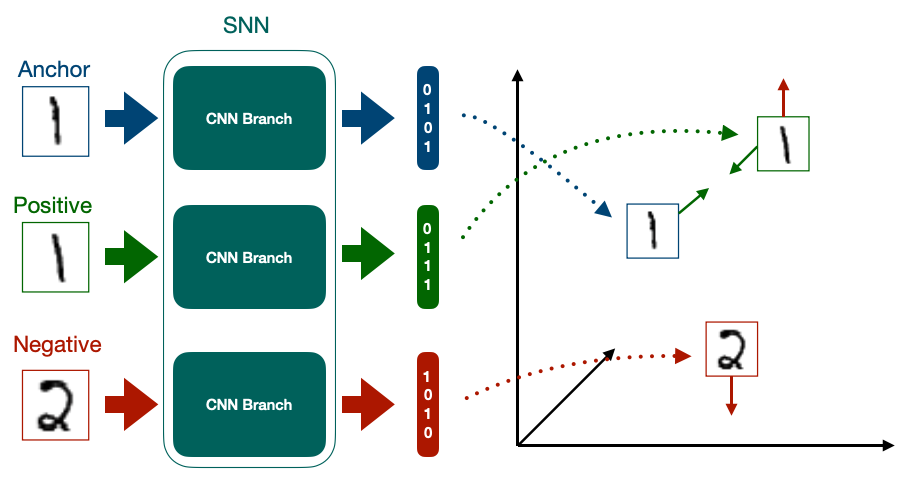

# Imports

In [ ]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[11]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

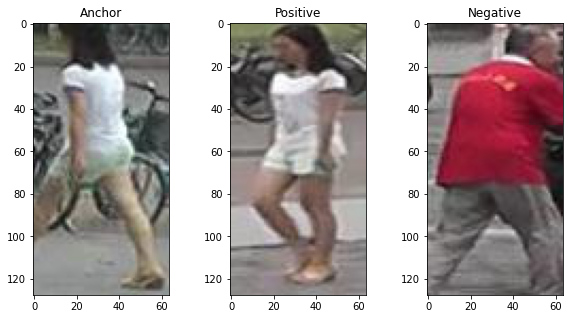

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Create APN Dataset 

In [ ]:
class APN_Dataset(Dataset):

  def __init__(self,df):
    self.df = df

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0 #(h, w, c) -> (c, h, w)
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0 #(h, w, c) -> (c, h, w)
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0 #(h, w, c) -> (c, h, w)

    return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 3200
Size of validset : 800


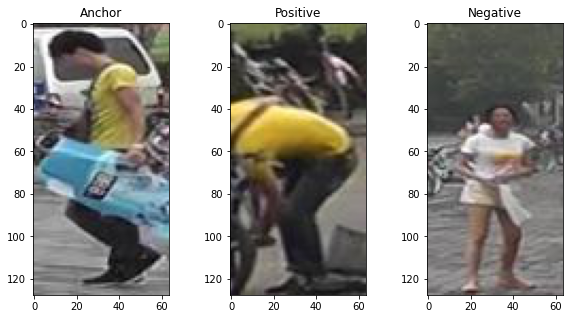

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [ ]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):

    embeddings = self.efficientnet(images)

    return embeddings

In [ ]:
model = APN_Model()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


# Create Train and Eval function

In [ ]:
def train_fn(mode, dataloader, optimizer, criterion):

  model.train() # turn on the layers of DROPOUT and BNORM
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    #A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [38]:
def eval_fn(mode, dataloader, criterion):

  model.eval() # turn on the layers of DROPOUT and BNORM
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      #A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

  return total_loss / len(dataloader)

In [39]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [40]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Saved_Weights!')
    best_valid_loss = valid_loss

  print(f'Epochs : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}')

100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


Saved_Weights!
Epochs : 1 train_loss : 0.4212020541727543 valid_loss : 0.33427228093147276


100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Saved_Weights!
Epochs : 2 train_loss : 0.1940756306052208 valid_loss : 0.2682134997844696


100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


Saved_Weights!
Epochs : 3 train_loss : 0.12541364803910254 valid_loss : 0.19946129441261293


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epochs : 4 train_loss : 0.07327937170863151 valid_loss : 0.21157857179641723


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Saved_Weights!
Epochs : 5 train_loss : 0.05945874273777008 valid_loss : 0.19181232362985612


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epochs : 6 train_loss : 0.07701505564153194 valid_loss : 0.24396858483552933


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Saved_Weights!
Epochs : 7 train_loss : 0.06813504830002785 valid_loss : 0.13075477927923201


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epochs : 8 train_loss : 0.039641753360629084 valid_loss : 0.16417747497558594


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epochs : 9 train_loss : 0.03511469773948193 valid_loss : 0.22261528611183168


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epochs : 10 train_loss : 0.04113058030605316 valid_loss : 0.22901001304388047


100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


Epochs : 11 train_loss : 0.02683773711323738 valid_loss : 0.14444257616996764


100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


Epochs : 12 train_loss : 0.027062505856156348 valid_loss : 0.15410928696393966


100%|██████████| 25/25 [00:20<00:00,  1.22it/s]


Epochs : 13 train_loss : 0.027787942215800287 valid_loss : 0.16725120544433594


100%|██████████| 25/25 [00:20<00:00,  1.23it/s]


Epochs : 14 train_loss : 0.03128845430910587 valid_loss : 0.1380573809146881


100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

Saved_Weights!
Epochs : 15 train_loss : 0.028518085181713105 valid_loss : 0.12117554157972336


# Get Anchor Embeddings

In [49]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      # A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) # (c, h, w) -> (bs, c, h, w)
      encodings.append(A_enc.squeeze().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [50]:
model.load_state_dict(torch.load('/content/best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [01:21<00:00, 49.36it/s]


In [51]:
df_enc.to_csv('database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.351776,0.018291,-0.349005,-0.213444,0.002537,0.341648,0.616977,0.216864,0.210947,...,-0.395799,0.760620,0.118188,0.008573,-0.436424,0.210214,0.090821,-0.914949,-0.176152,-0.454239
1,1420_c3s3_061978_03.jpg,0.304340,0.180259,-0.500703,-0.116257,0.114445,0.199832,0.620348,0.030553,0.171254,...,-0.507537,0.532402,0.119832,0.147256,-0.357362,0.116815,-0.021404,-0.798692,-0.054093,-0.442103
2,1420_c5s3_062565_05.jpg,0.366087,0.065101,-0.296792,-0.196284,0.069017,0.248138,0.608262,0.215137,0.159175,...,-0.422685,0.727524,0.022817,0.040853,-0.404003,0.147360,0.111612,-0.793846,-0.169204,-0.387560
3,1420_c6s3_085592_04.jpg,0.444173,-0.082191,-0.423690,-0.408545,-0.049502,0.188436,0.933270,0.315344,-0.089869,...,-0.593566,0.608801,-0.211555,-0.081974,-0.362849,-0.078559,0.123590,-0.644964,-0.074564,-0.182987
4,0663_c5s3_085987_03.jpg,-0.300884,-0.349250,-0.969180,-0.215635,-0.172771,-0.192922,0.792546,0.144011,-0.613743,...,-0.249128,-0.580274,-0.225276,-1.014383,0.273279,-0.277953,-0.606436,0.873029,0.292775,0.874427


# Inference

In [52]:
def euclidean_distance(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [61]:
idx = 4
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  # img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.numpy()

In [62]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [63]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_distance(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [72]:
closest_idx = np.argsort(distance)

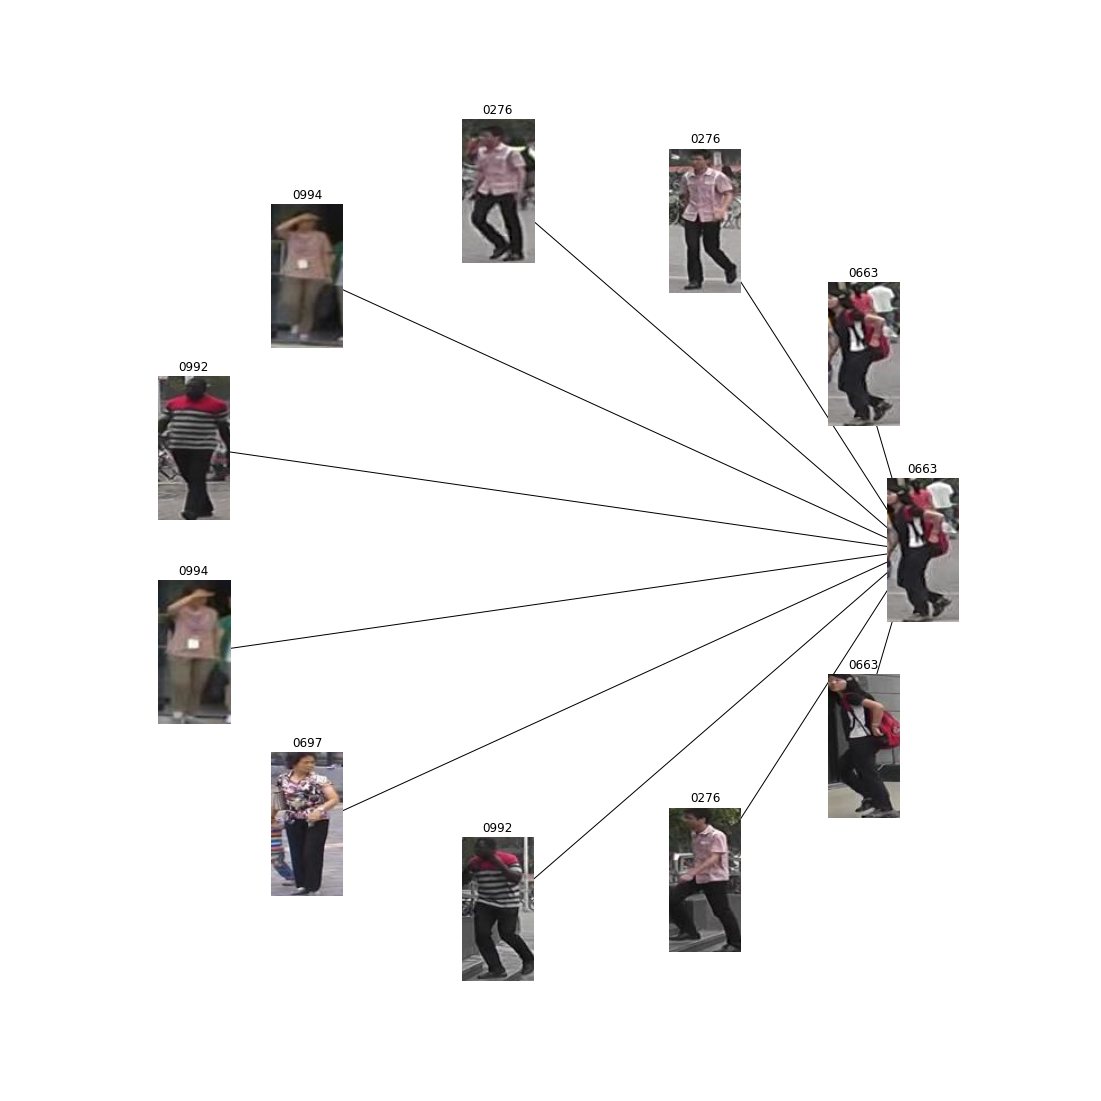

In [74]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);